In [63]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import os
import re
from string import punctuation

from nltk.stem.snowball import SnowballStemmer
from pymorphy2 import MorphAnalyzer

import random

import torch
from torch import nn, optim
from torchvision import transforms

In [64]:
df = pd.read_csv('less_7/train.csv')

In [65]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [66]:
df = df[['label','tweet']]

In [67]:
df = df.drop_duplicates(keep='first')

In [68]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [69]:
def transformer(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'ð', ' ', text)
    filtered_tokens = []
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    for token in tokens:
        if token not in stop_words and token != " " and token.strip() not in punctuation:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens if t not in stop_words]
    new_text = ' '.join(stems)

    return new_text

In [70]:
train_corpus = " ".join(df["tweet"])
train_corpus = train_corpus.lower()

In [71]:
tokens = [word for sent in nltk.sent_tokenize(train_corpus) for word in nltk.word_tokenize(sent)]

In [72]:
max_words = 2000
max_len = 40
num_classes = 1

In [73]:
from nltk.probability import FreqDist
dist = FreqDist(tokens)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [74]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [75]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [76]:
df['tweet'] = df['tweet'].apply(transformer)

In [77]:
df.head()

,label,tweet
0,0,user father dysfunct selfish drag kid dysfunct...
1,0,user user thank lyft credit use caus offer whe...
2,0,bihday majesti
3,0,model love u take u time ur
4,0,factsguid societi motiv


In [78]:
X = df.drop('label', axis = 1)
y = df['label']

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.33)

In [80]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
X_valid = np.asarray([text_to_sequence(text, max_len) for text in X_valid['tweet']])

In [81]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [82]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [83]:
from torch import nn


class RNNFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        rnn_out, ht = self.rnn(x) 
        # rnn_out: тензор с выходными фичами с последнего слоя для каждого t
        # h_t: тензор с последними скрытыми состояниями по слоям

        if self.use_last:
            last_tensor = rnn_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(rnn_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [84]:
# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [85]:
train_dataset = DataWrapper(X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(X_valid, y_valid.values)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [86]:
rnn_init = RNNFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(rnn_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [87]:
print(rnn_init)
print("Parameters:", sum([param.nelement() for param in rnn_init.parameters()]))

RNNFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (rnn): RNN(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 259861


In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rnn_init.to(device)
device

'cpu'

In [89]:
rnn_init = rnn_init.to(device)
rnn_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    rnn_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = rnn_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    rnn_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(valid_loader):
        test_labels = data[1].to(device)
        test_outputs = rnn_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [39/39]. Loss: 0.284. Acc: 0.932. Test loss: 0.466. Test acc: 0.931
Epoch [2/10]. Step [39/39]. Loss: 0.276. Acc: 0.932. Test loss: 0.228. Test acc: 0.931
Epoch [3/10]. Step [39/39]. Loss: 0.300. Acc: 0.932. Test loss: 0.367. Test acc: 0.931
Epoch [4/10]. Step [39/39]. Loss: 0.290. Acc: 0.932. Test loss: 0.524. Test acc: 0.931
Epoch [5/10]. Step [39/39]. Loss: 0.214. Acc: 0.932. Test loss: 0.376. Test acc: 0.931
Epoch [6/10]. Step [39/39]. Loss: 0.233. Acc: 0.932. Test loss: 0.544. Test acc: 0.931
Epoch [7/10]. Step [39/39]. Loss: 0.249. Acc: 0.932. Test loss: 0.377. Test acc: 0.931
Epoch [8/10]. Step [39/39]. Loss: 0.279. Acc: 0.932. Test loss: 0.382. Test acc: 0.931
Epoch [9/10]. Step [39/39]. Loss: 0.191. Acc: 0.932. Test loss: 0.234. Test acc: 0.931
Epoch [10/10]. Step [39/39]. Loss: 0.190. Acc: 0.932. Test loss: 0.213. Test acc: 0.931
Training is finished!


In [90]:
from torch import nn


class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [91]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [92]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 271381


In [93]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(valid_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [39/39]. Loss: 0.505. Acc: 0.578. Test loss: 0.513. Test acc: 0.931
Epoch [2/10]. Step [39/39]. Loss: 0.211. Acc: 0.932. Test loss: 0.651. Test acc: 0.931
Epoch [3/10]. Step [39/39]. Loss: 0.212. Acc: 0.932. Test loss: 0.381. Test acc: 0.931
Epoch [4/10]. Step [39/39]. Loss: 0.349. Acc: 0.932. Test loss: 0.224. Test acc: 0.931
Epoch [5/10]. Step [39/39]. Loss: 0.197. Acc: 0.932. Test loss: 0.070. Test acc: 0.931
Epoch [6/10]. Step [39/39]. Loss: 0.275. Acc: 0.932. Test loss: 0.225. Test acc: 0.931
Epoch [7/10]. Step [39/39]. Loss: 0.260. Acc: 0.932. Test loss: 0.224. Test acc: 0.931
Epoch [8/10]. Step [39/39]. Loss: 0.257. Acc: 0.932. Test loss: 0.223. Test acc: 0.931
Epoch [9/10]. Step [39/39]. Loss: 0.258. Acc: 0.932. Test loss: 0.351. Test acc: 0.931
Epoch [10/10]. Step [39/39]. Loss: 0.192. Acc: 0.932. Test loss: 0.377. Test acc: 0.931
Training is finished!


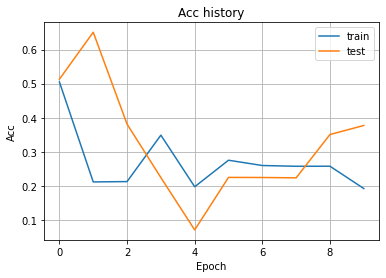

In [94]:
import matplotlib.pyplot as plt

plt.title('Acc history')
plt.grid(True)
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [95]:
from torch import nn


class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [96]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [97]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [98]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(valid_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/10]. Step [39/39]. Loss: 0.422. Acc: 0.608. Test loss: 0.355. Test acc: 0.931
Epoch [2/10]. Step [39/39]. Loss: 0.291. Acc: 0.932. Test loss: 0.226. Test acc: 0.931
Epoch [3/10]. Step [39/39]. Loss: 0.273. Acc: 0.932. Test loss: 0.225. Test acc: 0.931
Epoch [4/10]. Step [39/39]. Loss: 0.267. Acc: 0.932. Test loss: 0.528. Test acc: 0.931
Epoch [5/10]. Step [39/39]. Loss: 0.200. Acc: 0.932. Test loss: 0.377. Test acc: 0.931
Epoch [6/10]. Step [39/39]. Loss: 0.287. Acc: 0.932. Test loss: 0.065. Test acc: 0.931
Epoch [7/10]. Step [39/39]. Loss: 0.275. Acc: 0.932. Test loss: 0.065. Test acc: 0.931
Epoch [8/10]. Step [39/39]. Loss: 0.233. Acc: 0.932. Test loss: 0.176. Test acc: 0.931
Epoch [9/10]. Step [39/39]. Loss: 0.237. Acc: 0.932. Test loss: 0.227. Test acc: 0.931
Epoch [10/10]. Step [39/39]. Loss: 0.223. Acc: 0.932. Test loss: 0.222. Test acc: 0.931
Training is finished!


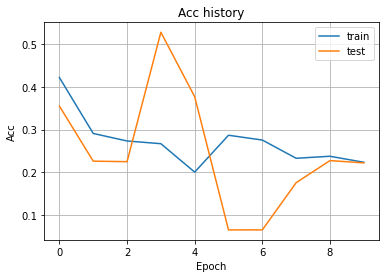

In [99]:
import matplotlib.pyplot as plt

plt.title('Acc history')
plt.grid(True)
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();